# Open Trust Fabric (OTF)
# Digital Platform Use Case
# 05- Listing Model
June 2021

# Description

This notebook provides a first model of indinvidual listings to identify the key featurs associated with asset price. The purpose of this model is to identify which features are actually influencing asset prices in digital platform contracts.

In [1]:
import pandas as pd
import numpy as np
import os
import gzip
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.linear_model import LinearRegression as lr

In [2]:
data_path = '../../../ecme/UC1: Digital Platform/Data/'

In [3]:
os.listdir(data_path)

['POLICY_NETWORK.csv.gzip',
 'Reviews_historical.csv.gzip',
 'PARTIES_DOMAIN_FEATURE.csv.gzip',
 'CONTRACT_PARTIES.csv.gzip',
 'total_reviews.csv',
 'CONTRACT_EVENTS.csv.gzip',
 'EVENTS_DOMAIN_FEATURE.csv.gzip',
 'total_listings.csv',
 'ASSETS_DOMAIN_FEATURE.csv.gzip',
 'Listing_historical.csv.gzip',
 'capitals.csv',
 'CONTRACT_ASSET.csv.gzip']

In [4]:
with gzip.open(data_path + 'ASSETS_DOMAIN_FEATURE.csv.gzip') as file_in:
    df_asset = pd.read_csv(file_in, low_memory=False)

In [5]:
df_asset.columns

Index(['MODEL_INSTANCE', 'PARTIES_ID', 'ASSET_ID', 'DATE_YEAR_MONTH',
       'ASSETS_NAME', 'ASSETS_TYPE', 'ASSETS_DESCRIPTION',
       'ASSETS_HOST_NEIGHBOURHOOD', 'ASSETS_NEIGHBORHOOD_OVERVIEW',
       'ASSETS_LATITUDE', 'ASSETS_LONGITUDE', 'ASSETS_PROPERTY_TYPE',
       'ASSETS_ROOM_TYPE', 'ASSETS_BEDROOMS', 'ASSETS_RETING_PRICE',
       'ASSETS_REQUIRES_LICENS', 'ASSETS_REVIEW_SCORES_ACCURACY',
       'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
       'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION',
       'ASSETS_REVIEW_SCORES_RATING', 'ASSETS_REVIEW_SCORES_VALUE',
       'ASSETS_REVIEW_PER_MONTH', 'PARTIES_ID_y', 'TIME_STAMP',
       'ASSET_MIGRATION', 'ASSET_LOCATION', 'ASSET_NUMBER_REVIEWS',
       'ASSET_PRICE', 'ASSET_AVAILABILITY_30'],
      dtype='object')

In [6]:
df_asset.rename(columns={'ASSET_MIGRATION' :'ASSET_MITIGATION_COVID'}, inplace=True)

In [7]:
df_asset.head()

,MODEL_INSTANCE,PARTIES_ID,ASSET_ID,DATE_YEAR_MONTH,ASSETS_NAME,ASSETS_TYPE,ASSETS_DESCRIPTION,ASSETS_HOST_NEIGHBOURHOOD,ASSETS_NEIGHBORHOOD_OVERVIEW,ASSETS_LATITUDE,...,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,ASSETS_REVIEW_PER_MONTH,PARTIES_ID_y,TIME_STAMP,ASSET_MITIGATION_COVID,ASSET_LOCATION,ASSET_NUMBER_REVIEWS,ASSET_PRICE,ASSET_AVAILABILITY_30
0,PJNs4Fpyg4,62142,15883,2015-04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rGvohKWuaC,62142,15883,2016-06,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,100.0,10.0,0.07,62142.0,2016-06-04,0.0,vienna,1.0,$85.00,9.0
2,O1ZE3GDKxL,62142,15883,2016-07,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,100.0,10.0,0.13,62142.0,2016-07-06,0.0,vienna,2.0,$85.00,17.0
3,2t2vxoLsH5,62142,15883,2016-08,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,93.0,9.0,0.19,62142.0,2016-08-05,0.0,vienna,3.0,$85.00,9.0
4,KBHJiEPuFf,62142,15883,2016-11,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,90.0,9.0,0.21,62142.0,2016-11-09,0.0,vienna,4.0,$85.00,9.0


In [8]:
df_count = pd.pivot_table(data=df_asset,
                          index="DATE_YEAR_MONTH",
                          columns="ASSET_LOCATION",
                          values="MODEL_INSTANCE",
                          aggfunc='count')

In [9]:
df_count['full_count'] = df_count.apply(lambda x: x.count(), axis=1)

In [10]:
df_count.tail(10)

ASSET_LOCATION,amsterdam,athens,brussels,copenhagen,dublin,lisbon,madrid,prague,rome,stockholm,vienna,full_count
DATE_YEAR_MONTH,,,,,,,,,,,,
2019-10,NaN,NaN,4218.0,1988.0,NaN,16187.0,NaN,8841.0,7.0,NaN,NaN,5
2019-11,NaN,6587.0,3809.0,1657.0,2765.0,11603.0,13569.0,6750.0,NaN,NaN,NaN,7
2019-12,NaN,5298.0,NaN,2026.0,2334.0,NaN,12951.0,2092.0,NaN,NaN,9180.0,6
2020-01,NaN,5599.0,3378.0,1625.0,NaN,NaN,12122.0,4769.0,NaN,NaN,6490.0,6
2020-02,NaN,5788.0,3756.0,1644.0,NaN,9923.0,12732.0,NaN,NaN,NaN,5887.0,6
2020-03,NaN,3533.0,1794.0,888.0,NaN,NaN,6647.0,3310.0,NaN,NaN,3010.0,6
2020-04,NaN,358.0,153.0,NaN,NaN,NaN,270.0,27.0,NaN,NaN,221.0,5
2020-05,233.0,NaN,245.0,NaN,215.0,91.0,563.0,280.0,NaN,NaN,427.0,7
2020-06,897.0,NaN,738.0,202.0,7.0,848.0,1209.0,NaN,NaN,NaN,1270.0,7


In [11]:
df_count[df_count.full_count == df_count.full_count.max()]

ASSET_LOCATION,amsterdam,athens,brussels,copenhagen,dublin,lisbon,madrid,prague,rome,stockholm,vienna,full_count
DATE_YEAR_MONTH,,,,,,,,,,,,
2018-04,4885.0,4058.0,NaN,1277.0,2308.0,8554.0,8560.0,4639.0,14998.0,455.0,3879.0,10


In [12]:
df_asset_sub = df_asset[df_asset.DATE_YEAR_MONTH == "2018-04"]

# periodo covid
#df_asset_sub = df_asset[df_asset.DATE_YEAR_MONTH == "2020-06"]

In [13]:
df_asset_sub.columns

Index(['MODEL_INSTANCE', 'PARTIES_ID', 'ASSET_ID', 'DATE_YEAR_MONTH',
       'ASSETS_NAME', 'ASSETS_TYPE', 'ASSETS_DESCRIPTION',
       'ASSETS_HOST_NEIGHBOURHOOD', 'ASSETS_NEIGHBORHOOD_OVERVIEW',
       'ASSETS_LATITUDE', 'ASSETS_LONGITUDE', 'ASSETS_PROPERTY_TYPE',
       'ASSETS_ROOM_TYPE', 'ASSETS_BEDROOMS', 'ASSETS_RETING_PRICE',
       'ASSETS_REQUIRES_LICENS', 'ASSETS_REVIEW_SCORES_ACCURACY',
       'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
       'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION',
       'ASSETS_REVIEW_SCORES_RATING', 'ASSETS_REVIEW_SCORES_VALUE',
       'ASSETS_REVIEW_PER_MONTH', 'PARTIES_ID_y', 'TIME_STAMP',
       'ASSET_MITIGATION_COVID', 'ASSET_LOCATION', 'ASSET_NUMBER_REVIEWS',
       'ASSET_PRICE', 'ASSET_AVAILABILITY_30'],
      dtype='object')

In [14]:
df_asset_sub.shape

(123649, 31)

In [15]:
df_asset_sub.head(3)

,MODEL_INSTANCE,PARTIES_ID,ASSET_ID,DATE_YEAR_MONTH,ASSETS_NAME,ASSETS_TYPE,ASSETS_DESCRIPTION,ASSETS_HOST_NEIGHBOURHOOD,ASSETS_NEIGHBORHOOD_OVERVIEW,ASSETS_LATITUDE,...,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,ASSETS_REVIEW_PER_MONTH,PARTIES_ID_y,TIME_STAMP,ASSET_MITIGATION_COVID,ASSET_LOCATION,ASSET_NUMBER_REVIEWS,ASSET_PRICE,ASSET_AVAILABILITY_30
240,576GOYB6Ov,166283,38768,2018-04,Hannes,Real Bed,39m² apartment with beautiful courtyard of the...,Leopoldstadt,the Karmeliterviertel became very pupular in t...,48.218225,...,95.0,9.0,2.7,166283.0,2018-04-14,0.0,vienna,232.0,$65.00,12.0
241,lWpdyw9J83,166283,38768,2018-04,Hannes,Real Bed,39m² apartment with beautiful courtyard of the...,Leopoldstadt,the Karmeliterviertel became very pupular in t...,48.218225,...,95.0,9.0,2.7,166283.0,2018-04-14,0.0,vienna,232.0,$65.00,12.0
242,L88aoWYExf,166283,38768,2018-04,Hannes,Real Bed,39m² apartment with beautiful courtyard of the...,Leopoldstadt,the Karmeliterviertel became very pupular in t...,48.218225,...,95.0,9.0,2.7,166283.0,2018-04-14,0.0,vienna,232.0,$65.00,12.0


In [16]:
#ASSET_PRICE
def fix_price (value):
    try:
        value = value.replace("$", '').replace(",", '')
        value = float(value)
        return value
    except: return np.nan  

df_asset_sub['ASSET_PRICE'] = df_asset_sub['ASSET_PRICE'].apply(lambda x : fix_price(x))

In [17]:
# CZK TO EURO --> 0.039
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='prague', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='prague', "ASSET_PRICE"] * 0.039

# DKK TO EURO --> 0.13
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='copenhagen', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='copenhagen', "ASSET_PRICE"] * 0.13

# KR TO EURO --> 0.099
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='stockholm', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='stockholm', "ASSET_PRICE"] * 0.099

In [18]:
anag = ["PARTIES_ID", "ASSET_ID"]

end_month = [
    "ASSETS_TYPE", 'ASSET_LOCATION',
    'ASSETS_REVIEW_PER_MONTH', 'ASSET_NUMBER_REVIEWS',
    'ASSET_AVAILABILITY_30', 
    'ASSET_MITIGATION_COVID']

med_month = [
'ASSET_PRICE',
'ASSETS_REVIEW_SCORES_ACCURACY', 'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION', 'ASSETS_REVIEW_SCORES_RATING', 
'ASSETS_REVIEW_SCORES_VALUE']


In [19]:
# seleziono soltando la riga relativa all'ultimo aggiornamento disponibile per ogni asset (listing)
# con questo approccio vengono eslusi i listing con time_stamp (data di aggiornamento) non disponibile (missing)

df_asset_end_month = df_asset_sub.sort_values(by=["ASSET_ID", "TIME_STAMP"])\
                                 .groupby(["ASSET_ID", "TIME_STAMP"])[anag + end_month].tail(1)

In [20]:
df_asset_end_month.ASSET_ID.duplicated().sum()

0

In [21]:
# un host può avere più listings
df_asset_end_month.PARTIES_ID.duplicated().sum()

4569

In [22]:
# ottengo una sola riga per listing come mediana dei valori nel periodo
df_asset_med_month = df_asset_sub.groupby(["ASSET_ID"])[med_month].median().reset_index()

In [23]:
df_asset_med_month.head(2)

,ASSET_ID,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2818,69.0,10.0,10.0,10.0,10.0,9.0,97.0,10.0


In [24]:
df_asset_med_month.ASSET_ID.duplicated().sum()

0

In [25]:
df_feature = df_asset_end_month.merge(df_asset_med_month, on = "ASSET_ID", how='left')

In [26]:
df_feature.head(2)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,3159,2818,Real Bed,amsterdam,2.02,222.0,10.0,0.0,69.0,10.0,10.0,10.0,10.0,9.0,97.0,10.0
1,3504,3079,Real Bed,rome,0.16,14.0,20.0,0.0,105.0,8.0,9.0,9.0,10.0,9.0,86.0,8.0


In [27]:
df_feature.shape

(14892, 16)

In [28]:
# ribilancio il campione sulla base della città con meno listings
gb = df_feature.groupby(['ASSET_LOCATION'])
df_feature = gb.apply(lambda x: x.sample(gb.size().min())).reset_index(drop=True)

In [29]:
df_feature.shape

(1530, 16)

In [30]:
with gzip.open(data_path + 'PARTIES_DOMAIN_FEATURE.csv.gzip') as file_in:
    df_parties = pd.read_csv(file_in, low_memory=False)

In [31]:
df_parties.head(2)

,TIME_STAMP_MONTH,PARTIES_ID,HOST_NAME,HOST_SINCE,HOST_LOCATION,HOST_ABOUT,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC,TIME_STAMP,PARTIES_ROLE
0,2021-04,62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,NaN,NaN,100%,f,6.0,t,2021-04-15,H
1,2021-04,166283,Hannes,2010-07-14,"Vienna, Wien, Austria",I am open minded and like travelling myself. I...,within an hour,100%,98%,t,3.0,t,2021-04-15,H


In [32]:
# seleziono solo l'ultima informazione disponibile per ogni host

df_parties = df_parties[(df_parties.PARTIES_ROLE == 'H') &
                        (df_parties.TIME_STAMP_MONTH == '2018-04')]\
                        .sort_values(['TIME_STAMP'])\
                        .groupby("PARTIES_ID").tail(1)[["PARTIES_ID", 
                                                        'HOST_RESPONSE_TIME','HOST_RESPONCE_RATE', 
                                                        'HOST_ACCEPTANCE_RATE', 'HOST_IS_SUPERHOST',
                                                        'HOST_LISTINGS_COUNT', 'HOST_HAS_PROFILE_PIC']]

In [33]:
df_parties.head(2)

,PARTIES_ID,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC
8752674,4059485.0,NaN,NaN,NaN,f,1.0,t
8754465,169989843.0,within an hour,100%,NaN,f,1.0,t


In [34]:
df_parties.PARTIES_ID = df_parties.PARTIES_ID.astype(float)

In [35]:
df_parties.dtypes

PARTIES_ID              float64
HOST_RESPONSE_TIME       object
HOST_RESPONCE_RATE       object
HOST_ACCEPTANCE_RATE     object
HOST_IS_SUPERHOST        object
HOST_LISTINGS_COUNT     float64
HOST_HAS_PROFILE_PIC     object
dtype: object

In [36]:
df_feature = df_feature.merge(df_parties, on='PARTIES_ID', how='left')

In [37]:
df_feature.shape

(1530, 22)

In [38]:
df_feature.ASSET_ID.duplicated().sum()

0

In [39]:
df_feature.isnull().sum() / df_feature.shape[0] * 100

PARTIES_ID                              0.000000
ASSET_ID                                0.000000
ASSETS_TYPE                             0.000000
ASSET_LOCATION                          0.000000
ASSETS_REVIEW_PER_MONTH                 0.000000
ASSET_NUMBER_REVIEWS                    0.000000
ASSET_AVAILABILITY_30                   0.000000
ASSET_MITIGATION_COVID                  0.000000
ASSET_PRICE                             0.000000
ASSETS_REVIEW_SCORES_ACCURACY           0.000000
ASSETS_REVIEW_SCORES_CHECKIN            0.000000
ASSETS_REVIEW_SCORES_CLEANLINESS        0.000000
ASSETS_REVIEW_SCORES_COMMUNICATION      0.000000
ASSETS_REVIEW_SCORES_LOCATION           0.000000
ASSETS_REVIEW_SCORES_RATING             0.000000
ASSETS_REVIEW_SCORES_VALUE              0.000000
HOST_RESPONSE_TIME                      0.718954
HOST_RESPONCE_RATE                      0.718954
HOST_ACCEPTANCE_RATE                  100.000000
HOST_IS_SUPERHOST                       0.065359
HOST_LISTINGS_COUNT 

In [40]:
df_feature.drop(columns=["HOST_ACCEPTANCE_RATE"], inplace=True)

In [41]:
df_feature.HOST_RESPONCE_RATE = df_feature.HOST_RESPONCE_RATE.str.replace('%', '').astype(float)

In [42]:
df_feature.dtypes

PARTIES_ID                              int64
ASSET_ID                                int64
ASSETS_TYPE                            object
ASSET_LOCATION                         object
ASSETS_REVIEW_PER_MONTH               float64
ASSET_NUMBER_REVIEWS                  float64
ASSET_AVAILABILITY_30                 float64
ASSET_MITIGATION_COVID                float64
ASSET_PRICE                           float64
ASSETS_REVIEW_SCORES_ACCURACY         float64
ASSETS_REVIEW_SCORES_CHECKIN          float64
ASSETS_REVIEW_SCORES_CLEANLINESS      float64
ASSETS_REVIEW_SCORES_COMMUNICATION    float64
ASSETS_REVIEW_SCORES_LOCATION         float64
ASSETS_REVIEW_SCORES_RATING           float64
ASSETS_REVIEW_SCORES_VALUE            float64
HOST_RESPONSE_TIME                     object
HOST_RESPONCE_RATE                    float64
HOST_IS_SUPERHOST                      object
HOST_LISTINGS_COUNT                   float64
HOST_HAS_PROFILE_PIC                   object
dtype: object

### Check Distributions

#### Categorical

In [43]:
df_feature.ASSET_LOCATION.value_counts() / len(df_feature) * 100

prague        10.0
vienna        10.0
madrid        10.0
dublin        10.0
amsterdam     10.0
stockholm     10.0
lisbon        10.0
copenhagen    10.0
rome          10.0
athens        10.0
Name: ASSET_LOCATION, dtype: float64

In [44]:
# not very useful
df_feature.ASSETS_TYPE.value_counts() / len(df_feature) * 100

Real Bed         98.562092
Pull-out Sofa     1.111111
Futon             0.261438
Couch             0.065359
Name: ASSETS_TYPE, dtype: float64

In [45]:
df_feature.HOST_RESPONSE_TIME.value_counts() / len(df_feature) * 100

within an hour        77.777778
within a few hours    13.921569
within a day           7.320261
a few days or more     0.261438
Name: HOST_RESPONSE_TIME, dtype: float64

In [46]:
df_feature.HOST_IS_SUPERHOST.value_counts() / len(df_feature) * 100

f    56.274510
t    43.660131
Name: HOST_IS_SUPERHOST, dtype: float64

In [47]:
# not useful, almost everybody has a picture
df_feature.HOST_HAS_PROFILE_PIC.value_counts()  / len(df_feature) * 100

t    99.803922
f     0.130719
Name: HOST_HAS_PROFILE_PIC, dtype: float64

In [48]:
numerical_features = [
    "ASSETS_REVIEW_PER_MONTH",
    "ASSET_NUMBER_REVIEWS",                  
    "ASSET_AVAILABILITY_30",                 
    "ASSET_PRICE",                
    "ASSETS_REVIEW_SCORES_ACCURACY",
    "ASSETS_REVIEW_SCORES_CHECKIN",          
    "ASSETS_REVIEW_SCORES_CLEANLINESS",
    "ASSETS_REVIEW_SCORES_COMMUNICATION",    
    "ASSETS_REVIEW_SCORES_LOCATION",         
    "ASSETS_REVIEW_SCORES_RATING",           
    "ASSETS_REVIEW_SCORES_VALUE",
    "HOST_RESPONCE_RATE",
    "HOST_LISTINGS_COUNT"]

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

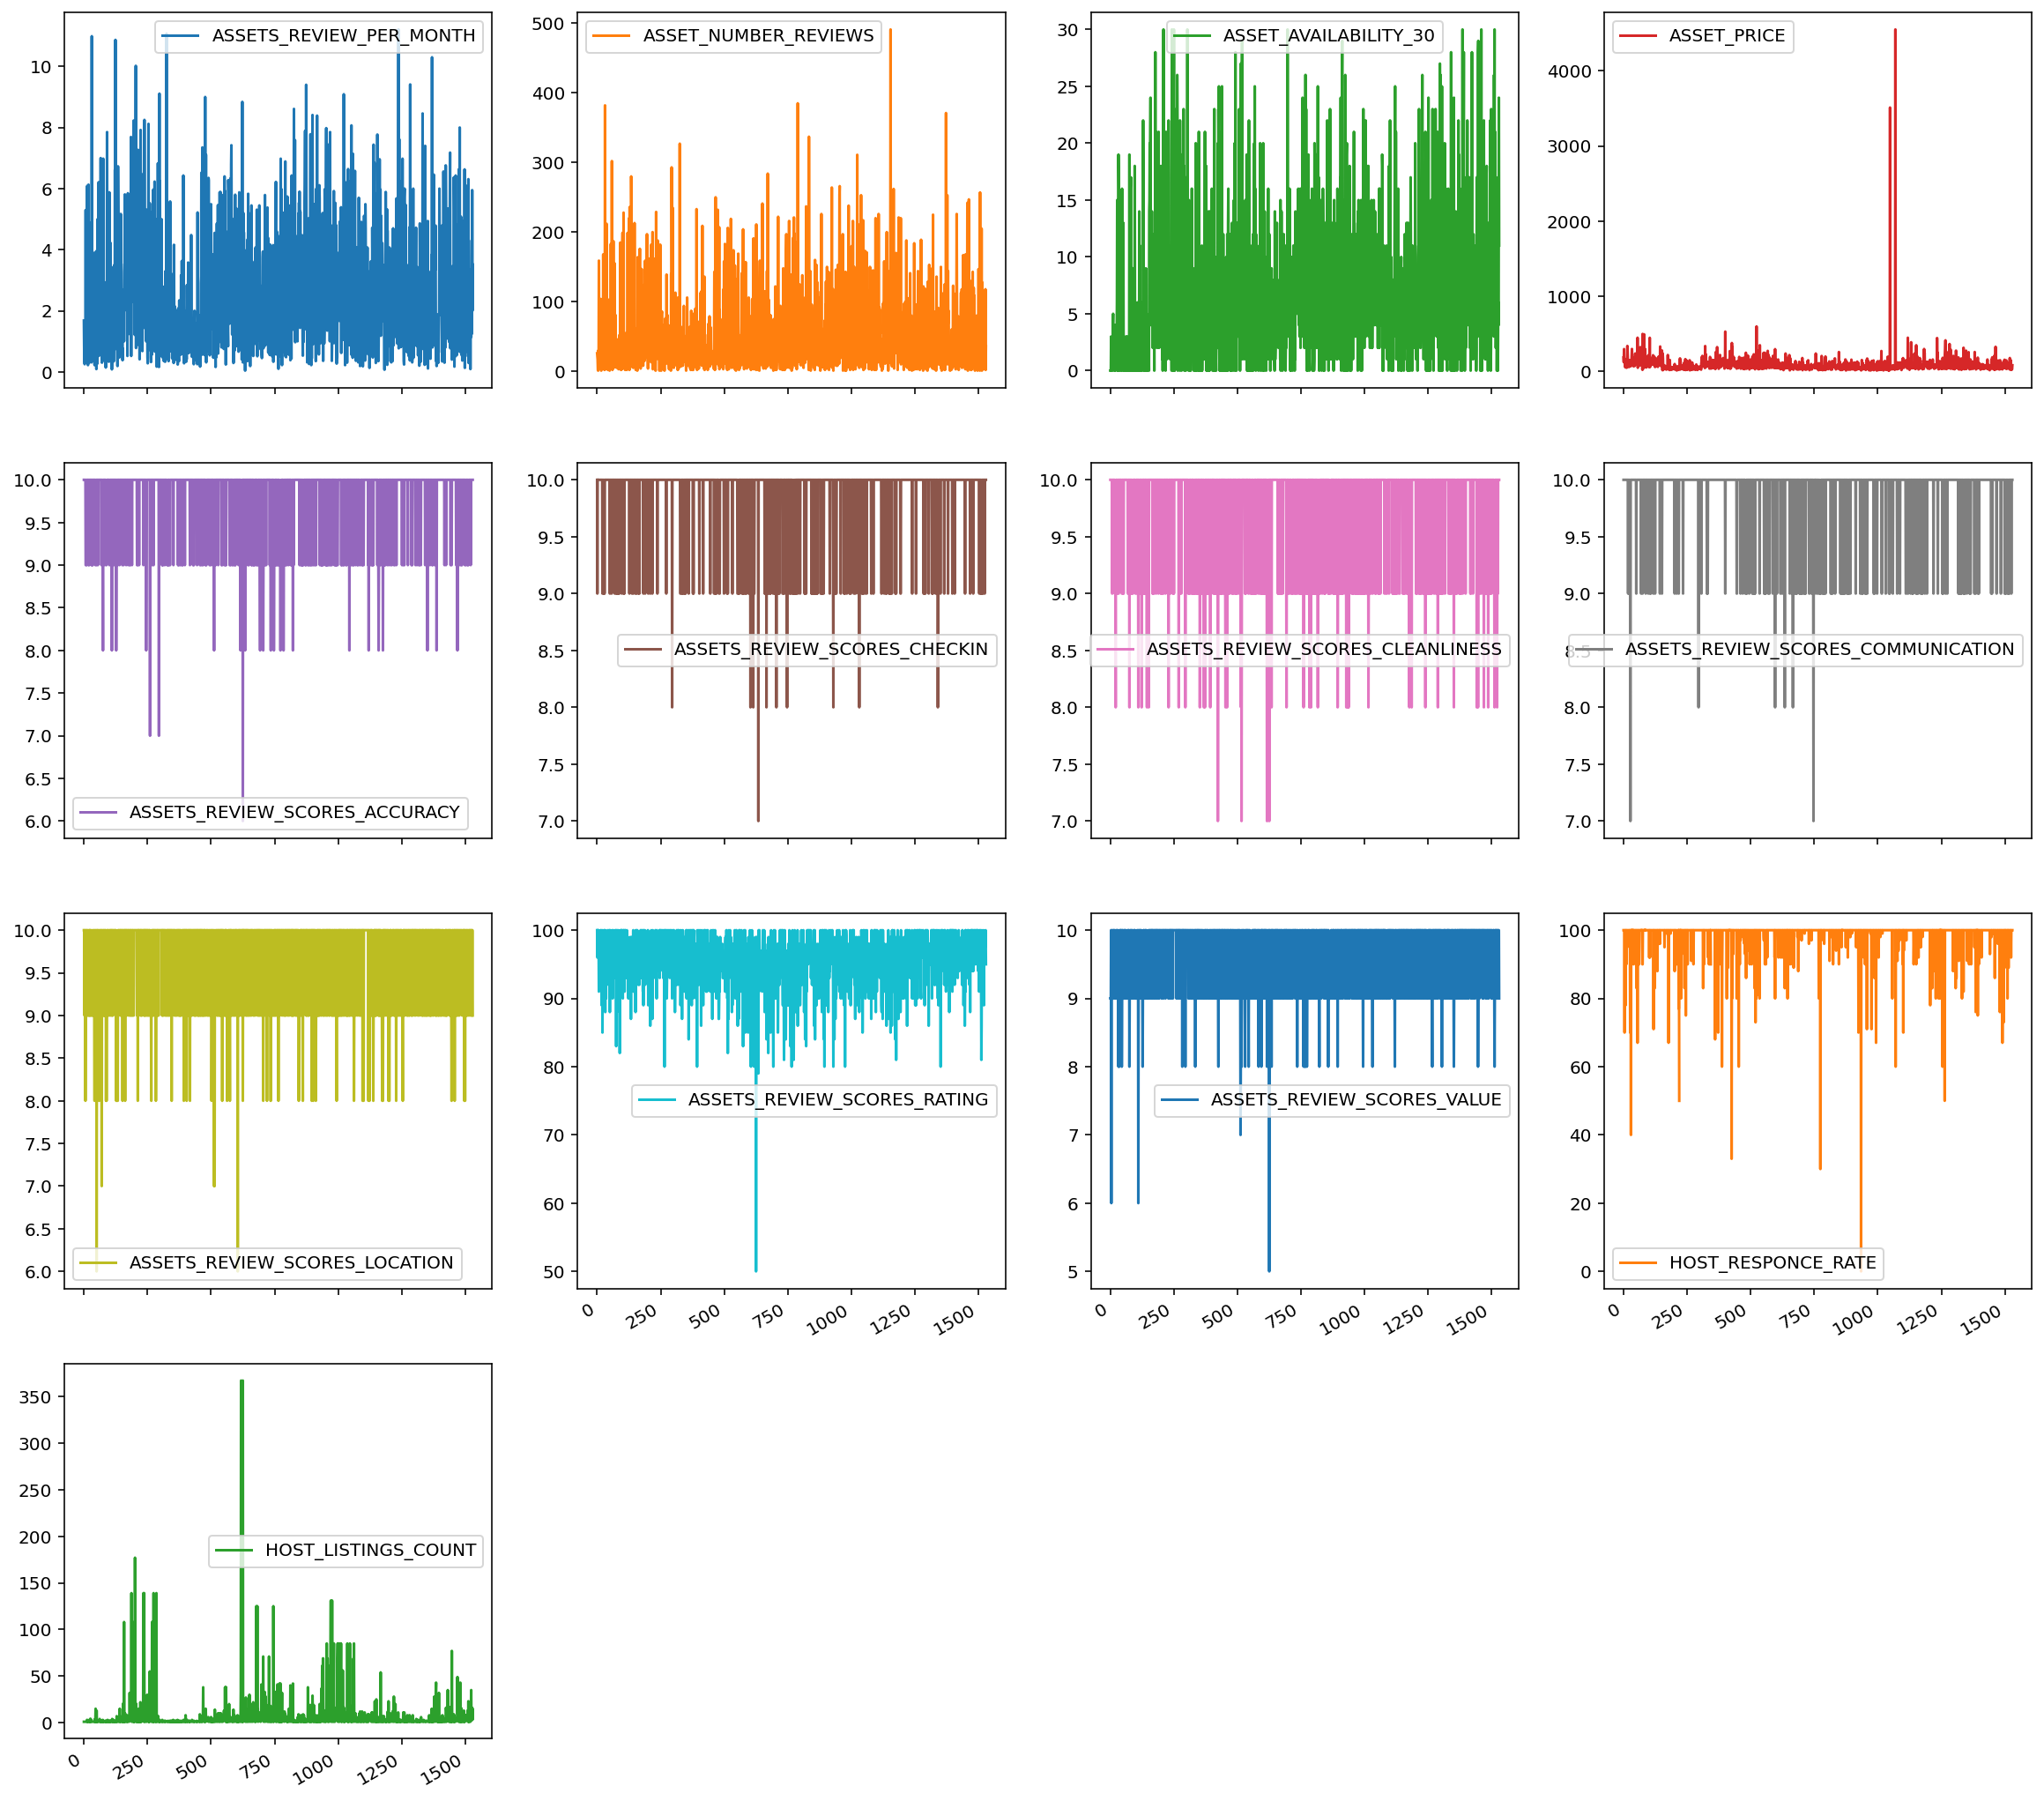

In [49]:
df_feature[numerical_features].plot(subplots=True, layout=(4,4), figsize=(20, 20))

In [50]:
# escludo gli asset con prezzo > 1000. Possibili anomalie di inserimento o altro
df_feature = df_feature[df_feature.ASSET_PRICE < 1000]

In [51]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].head(3)

,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,10.0,100.0,9.0
1,10.0,96.0,9.0
2,10.0,98.0,9.0


In [52]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].corr()

,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
ASSETS_REVIEW_SCORES_ACCURACY,1.000000,0.619794,0.499521
ASSETS_REVIEW_SCORES_RATING,0.619794,1.000000,0.616719
ASSETS_REVIEW_SCORES_VALUE,0.499521,0.616719,1.000000


In [53]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].isnull().sum()

ASSETS_REVIEW_SCORES_ACCURACY    0
ASSETS_REVIEW_SCORES_RATING      0
ASSETS_REVIEW_SCORES_VALUE       0
dtype: int64

In [54]:
# scelgo di tenere solo ASSETS_REVIEW_SCORES_RATING --> avendo una scala più ampia magari conserva anche più variabilità

In [55]:
# per tutte le variabili che indicano caratteristiche del listing, faccio una media dei diversi voti
df_feature["ASSETS_REVIEW_SCORES_AVG"] = df_feature[["ASSETS_REVIEW_SCORES_CHECKIN", "ASSETS_REVIEW_SCORES_CLEANLINESS", 
                                                     "ASSETS_REVIEW_SCORES_COMMUNICATION", "ASSETS_REVIEW_SCORES_LOCATION",
                                                     "ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_VALUE"]]\
                                        .mean(axis=1).round(2)

df_feature.drop(columns=["ASSETS_REVIEW_SCORES_CHECKIN", "ASSETS_REVIEW_SCORES_CLEANLINESS", 
                "ASSETS_REVIEW_SCORES_COMMUNICATION", "ASSETS_REVIEW_SCORES_LOCATION",
                "ASSETS_REVIEW_SCORES_ACCURACY","ASSETS_REVIEW_SCORES_VALUE"], axis=1, inplace=True)

In [56]:
# creo la variabile occupancy come differenza rispetto ai gg del mese

df_feature['OCCUPANCY'] = 30 - df_feature["ASSET_AVAILABILITY_30"]
df_feature.drop("ASSET_AVAILABILITY_30", axis=1, inplace=True)

In [57]:
# dumming delle variabili categoriche scelte

dummies_cols = [
                "ASSET_LOCATION", 
                "HOST_RESPONSE_TIME", 
                "HOST_IS_SUPERHOST", 
               ]

col_to_drop = ["ASSETS_TYPE", "HOST_HAS_PROFILE_PIC"]

for col in dummies_cols:
    df_feature = df_feature.join(pd.get_dummies(df_feature[col], prefix=col))
    df_feature.drop(col, axis=1, inplace=True)

df_feature.drop(col_to_drop, axis=1, inplace=True)

In [58]:
df_feature.columns

Index(['PARTIES_ID', 'ASSET_ID', 'ASSETS_REVIEW_PER_MONTH',
       'ASSET_NUMBER_REVIEWS', 'ASSET_MITIGATION_COVID', 'ASSET_PRICE',
       'ASSETS_REVIEW_SCORES_RATING', 'HOST_RESPONCE_RATE',
       'HOST_LISTINGS_COUNT', 'ASSETS_REVIEW_SCORES_AVG', 'OCCUPANCY',
       'ASSET_LOCATION_amsterdam', 'ASSET_LOCATION_athens',
       'ASSET_LOCATION_copenhagen', 'ASSET_LOCATION_dublin',
       'ASSET_LOCATION_lisbon', 'ASSET_LOCATION_madrid',
       'ASSET_LOCATION_prague', 'ASSET_LOCATION_rome',
       'ASSET_LOCATION_stockholm', 'ASSET_LOCATION_vienna',
       'HOST_RESPONSE_TIME_a few days or more',
       'HOST_RESPONSE_TIME_within a day',
       'HOST_RESPONSE_TIME_within a few hours',
       'HOST_RESPONSE_TIME_within an hour', 'HOST_IS_SUPERHOST_f',
       'HOST_IS_SUPERHOST_t'],
      dtype='object')

In [59]:
df_feature.head()

,PARTIES_ID,ASSET_ID,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_MITIGATION_COVID,ASSET_PRICE,ASSETS_REVIEW_SCORES_RATING,HOST_RESPONCE_RATE,HOST_LISTINGS_COUNT,ASSETS_REVIEW_SCORES_AVG,...,ASSET_LOCATION_prague,ASSET_LOCATION_rome,ASSET_LOCATION_stockholm,ASSET_LOCATION_vienna,HOST_RESPONSE_TIME_a few days or more,HOST_RESPONSE_TIME_within a day,HOST_RESPONSE_TIME_within a few hours,HOST_RESPONSE_TIME_within an hour,HOST_IS_SUPERHOST_f,HOST_IS_SUPERHOST_t
0,107372728,16391366,1.68,26.0,0.0,187.0,100.0,100.0,1.0,9.83,...,0,0,0,0,0,0,0,1,0,1
1,42098095,7976249,0.73,21.0,0.0,125.0,96.0,100.0,1.0,9.67,...,0,0,0,0,0,0,1,0,1,0
2,9314105,1927634,0.38,17.0,0.0,299.0,98.0,100.0,1.0,9.67,...,0,0,0,0,0,0,0,1,1,0
3,15158082,19938339,0.25,2.0,0.0,120.0,100.0,100.0,1.0,10.00,...,0,0,0,0,0,1,0,0,1,0
4,45378102,19434388,1.00,1.0,0.0,125.0,100.0,70.0,1.0,9.33,...,0,0,0,0,0,1,0,0,1,0


In [60]:
df_feature.isnull().sum()

PARTIES_ID                                0
ASSET_ID                                  0
ASSETS_REVIEW_PER_MONTH                   0
ASSET_NUMBER_REVIEWS                      0
ASSET_MITIGATION_COVID                    0
ASSET_PRICE                               0
ASSETS_REVIEW_SCORES_RATING               0
HOST_RESPONCE_RATE                       11
HOST_LISTINGS_COUNT                       1
ASSETS_REVIEW_SCORES_AVG                  0
OCCUPANCY                                 0
ASSET_LOCATION_amsterdam                  0
ASSET_LOCATION_athens                     0
ASSET_LOCATION_copenhagen                 0
ASSET_LOCATION_dublin                     0
ASSET_LOCATION_lisbon                     0
ASSET_LOCATION_madrid                     0
ASSET_LOCATION_prague                     0
ASSET_LOCATION_rome                       0
ASSET_LOCATION_stockholm                  0
ASSET_LOCATION_vienna                     0
HOST_RESPONSE_TIME_a few days or more     0
HOST_RESPONSE_TIME_within a day 

In [61]:
# elimino gli na per costruire il modello
df_feature.dropna(inplace=True)

In [62]:
df_feature.shape

(1517, 27)

#### MODEL

In [63]:
#X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "OCCUPANCY"]]]
X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "ASSET_PRICE"]]]
#X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "ASSET_NUMBER_REVIEWS"]]]

In [64]:
#y = df_feature["OCCUPANCY"]
y = df_feature["ASSET_PRICE"]
#y = df_feature["ASSET_NUMBER_REVIEWS"]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [66]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#### Decision Tree Regressor

In [67]:
model = dtr(max_depth=10, 
            min_samples_split=0.1, 
            min_samples_leaf=0.05, 
            random_state=101)

model.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.05,
                      min_samples_split=0.1, random_state=101)

In [68]:
pred = model.predict(X_test)

In [69]:
mape(pred, y_test.values)

48.1837621719425

In [70]:
importance = model.feature_importances_
columns = list(X_train)

df_feat_imp = pd.DataFrame({'feature' : columns, 'importance' : importance})
df_feat_imp.sort_values(by='importance', ascending = False, inplace=True)

<AxesSubplot:ylabel='feature'>

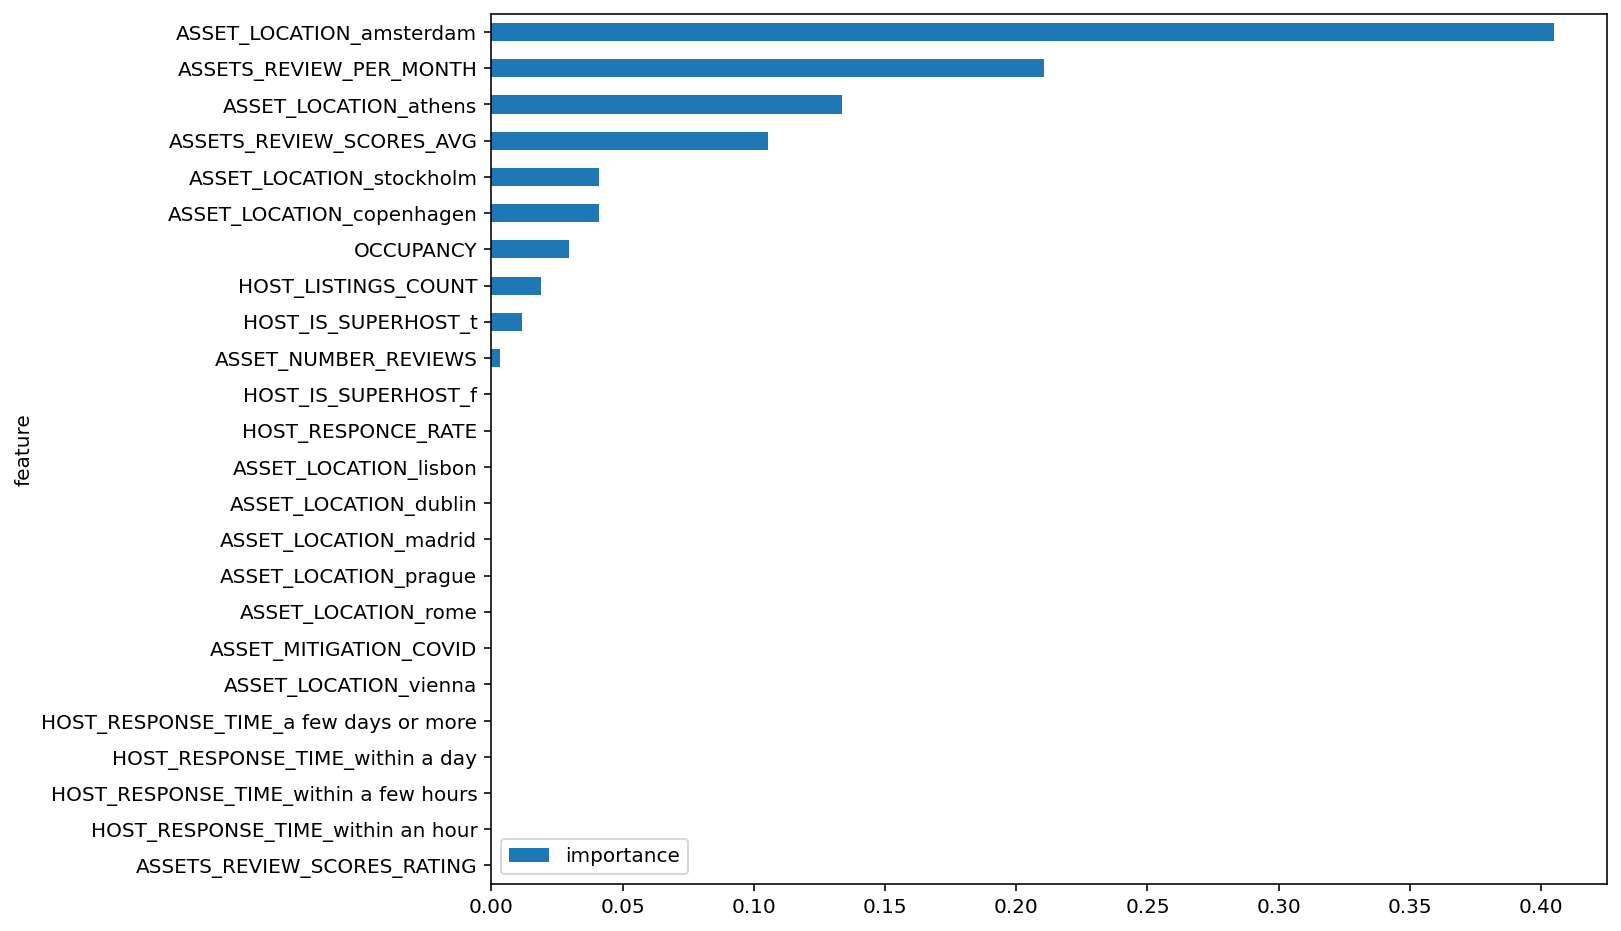

In [71]:
df_feat_imp.sort_values(by='importance', ascending = True)\
           .plot.barh(x="feature", y="importance", figsize=(10, 8))

In [72]:
df_test = pd.DataFrame({'actual' : y_test.values, 'predicted' : pred})

In [73]:
df_test.sort_values(by='actual').head(10)

,actual,predicted
119,13.650,107.549190
442,14.469,93.334923
286,18.000,65.846590
106,18.000,105.760517
163,18.369,76.052752
28,19.000,58.670355
343,19.149,76.052752
158,19.968,94.578875
290,19.968,107.549190
195,20.000,58.670355


In [74]:
df_feature[df_feature.OCCUPANCY < 5].shape[0] / df_feature.shape[0]

0.016479894528675015

#### Regression

In [75]:
reg = lr().fit(X_train, y_train)

In [76]:
# coefficient of determination R2 of the prediction.
reg.score(X_train, y_train)

0.23398226969670433

In [77]:
reg.coef_

array([-4.96121220e+00, -6.33418427e-03,  1.59872116e-14,  1.12091840e+00,
       -3.10237992e-01,  2.04753574e-01,  9.40219057e+00, -6.87773639e-01,
        5.86614505e+01, -4.06137054e+01,  1.83796667e+01,  2.03472890e+01,
       -1.41685266e+01, -1.25870808e+01, -2.27880481e+01,  2.51474209e+00,
        9.92911202e+00, -1.96748994e+01, -7.50031856e+01,  2.58625839e+01,
        2.86450400e+01,  2.04955617e+01, -4.89170410e+00,  4.89170410e+00])

In [78]:
lr_pred = reg.predict(X_test)

In [79]:
mape(lr_pred, y_test.values)

53.21895967126652

In [80]:
df_test_lr = pd.DataFrame({'actual' : y_test.values, 'predicted' : lr_pred})

In [81]:
df_test_lr.sort_values(by='actual').head(10)

,actual,predicted
119,13.650,52.240414
442,14.469,67.433165
286,18.000,68.994244
106,18.000,71.825873
163,18.369,78.328198
28,19.000,60.200706
343,19.149,58.527010
158,19.968,91.425731
290,19.968,68.421698
195,20.000,61.799914
